# Notebook 15 - Opinion Spam Investigation

Large numbers of deceptive reviews will distort the integrity of the data and therefore the reliability of any models based upon that data.This notebook investigates fake reviews using a range of methods from the research in this area.

* Section 1 - Import the Data and Libraries
* Section 2 - Exploratory Data Analysis
* Section 3 - Duplicate Reviews investigation
* Section 4 - First-time Contributors
* Section 5 - Linguistic Patterns
* Section 6 - Linguistic Patterns
* Section 7 - TripAdvisor Opinion Spam for Accommodation ML model
* Section 8 - Predict against the Arun Accommodation Reviews
* Section 9 - YELP Spam Reviews for Restaurants
* Section 10 - Predict against a Subset of Arun Restaurant Reviews


This notebook uses the following dataset files:

* deceptive-opinion.csv
* "combined_df.csv"



# Section 1: Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import string
import warnings
warnings.filterwarnings("ignore")
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,f1_score,fbeta_score,f1_score,precision_score,recall_score

pd.set_option('display.max_rows', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Read in Cornell deceptive opinions dataset
cornell = pd.read_csv("deceptive-opinion.csv")

# Section 2: Exploratory Analysis

## Cornell Deceptive TripAdvisor Opinion Spam Dataset for Hotels

Dataset Source:

This corpus consists of truthful and deceptive hotel reviews of 20 Chicago hotels.

* 400 truthful positive reviews from TripAdvisor (described in [1])

* 400 deceptive positive reviews from Mechanical Turk (described in [1])

* 400 truthful negative reviews from Expedia, Hotels.com, Orbitz, Priceline, TripAdvisor and Yelp (described in [2])

* 400 deceptive negative reviews from Mechanical Turk (described in [2])

[1] M. Ott, Y. Choi, C. Cardie, and J.T. Hancock. 2011. Finding Deceptive Opinion Spam by Any Stretch of the Imagination. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies.

[2] M. Ott, C. Cardie, and J.T. Hancock. 2013. Negative Deceptive Opinion Spam. In Proceedings of the 2013 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies.


https://myleott.com/op-spam.html


In [3]:
# Check first few rows of dataframe
cornell.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [4]:
cornell.deceptive.value_counts()

deceptive    800
truthful     800
Name: deceptive, dtype: int64

In [5]:
# Drop unwanted columns
cornell.drop(columns = ["hotel","source"],axis = 1, inplace = True)
cornell.head()

,deceptive,polarity,text
0,truthful,positive,We stayed for a one night getaway with family ...
1,truthful,positive,Triple A rate with upgrade to view room was le...
2,truthful,positive,This comes a little late as I'm finally catchi...
3,truthful,positive,The Omni Chicago really delivers on all fronts...
4,truthful,positive,I asked for a high floor away from the elevato...


In [6]:
# Examine the features
cornell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   polarity   1600 non-null   object
 2   text       1600 non-null   object
dtypes: object(3)
memory usage: 37.6+ KB


In [7]:
# Get character length for all reviews and then get the mean and median for those marked as deceptive and those marked as truthful
cornell["char_len"] = cornell["text"].str.len()
decept = cornell[cornell["deceptive"] == "deceptive"]["char_len"]
true = cornell[cornell["deceptive"] == "truthful"]["char_len"]

In [8]:
decept.describe()

count     800.000000
mean      791.767500
std       449.016264
min       151.000000
25%       483.750000
50%       680.500000
75%       985.000000
max      4075.000000
Name: char_len, dtype: float64

In [9]:
true.describe()

count     800.000000
mean      821.015000
std       484.659089
min       168.000000
25%       491.000000
50%       710.500000
75%       993.250000
max      4159.000000
Name: char_len, dtype: float64

In [10]:
print(decept.median())
print(true.median())

680.5
710.5


Text(0, 0.5, 'Number')

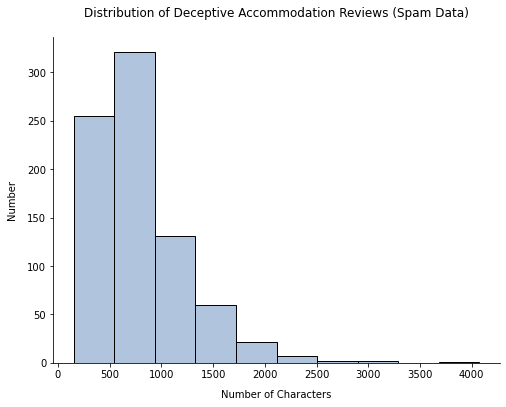

In [11]:
# Plot distributions

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(decept, bins = 10, color = "lightsteelblue",ec = "black")
ax.set_title("Distribution of Deceptive Accommodation Reviews (Spam Data)", fontsize = 12, pad = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Number of Characters",labelpad = 10)
ax.set_ylabel("Number", labelpad = 10)

Text(0, 0.5, 'Number')

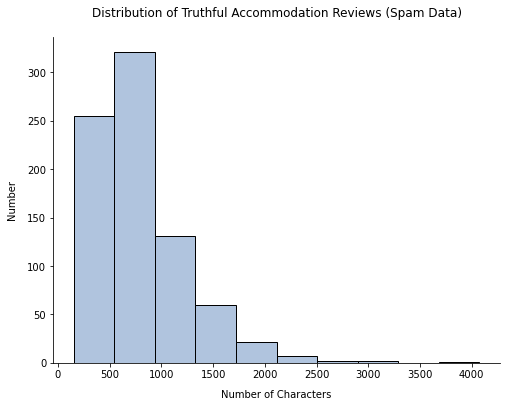

In [12]:
# Plot distributions
fig, ax = plt.subplots(figsize = (8,6))

ax.hist(decept, bins = 10, color = "lightsteelblue",ec = "black")
ax.set_title("Distribution of Truthful Accommodation Reviews (Spam Data)", fontsize = 12, pad = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Number of Characters",labelpad = 10)
ax.set_ylabel("Number", labelpad = 10)

Truthful reviews are slightly longer on average than deceptive reviews.

In [13]:
# convert strings to numbers
cornell.deceptive[cornell.deceptive == 'truthful'] = 0
cornell.deceptive[cornell.deceptive == 'deceptive'] = 1

# convert object type to int
cornell.deceptive = cornell.deceptive.astype(float)

## YELP Dataset for Restaurant Reviews

Sample dataset taken from the original - 350,000 YELP restaurant reviews with filtered (deceptive) and true labels originally from:

Source:Rayana, Shebuti & Akoglu, Leman. (2015). Collective Opinion Spam Detection. 985-994. 10.1145/2783258.2783370. 

http://odds.cs.stonybrook.edu/yelpzip-dataset/

files downloaded from:

https://github.com/zzhang83/Yelp_Sentiment_Analysis


In [14]:
reviewContent = pd.read_table("reviewContent",names=["user_id","name","date","review"])
df_review = pd.DataFrame(reviewContent)

metadata = pd.read_table("metadata",names=["user_id", "prod_id", "rating", "label", "date"])
df_metadata = pd.DataFrame(metadata)

combined = pd.concat([df_review,df_metadata],axis=1,join="inner")
combined = combined.dropna()

yelp = combined[["label","review"]]


In [15]:
yelp.shape

(358957, 2)

In [16]:
yelp.head()

,label,review
0,-1,The food at snack is a selection of popular Gr...
1,-1,This little place in Soho is wonderful. I had ...
2,-1,ordered lunch for 15 from Snack last Friday. ...
3,-1,This is a beautiful quaint little restaurant o...
4,-1,Snack is great place for a casual sit down lu...


In [17]:
# Length of strings in the reviews and get mean (compare to Arun dataset food reviews to ensure comparable)
yelp["char_len"] = yelp["review"].str.len()
print(yelp["char_len"].mean())

635.1789573681527


In [18]:
# Get number of true and deceptive reviews
yelp.label.value_counts()

 1    322072
-1     36885
Name: label, dtype: int64

## Arun Dataset

In [19]:
# Read in dataset of actual reviews
arun_df = pd.read_csv("combined_df.csv",usecols = ["User","ReviewDate","Name","Category","Contributions","Title","Review","Rating"])

In [20]:
accom = arun_df[arun_df["Category"] == "Accommodation"]

In [21]:
accom.shape

(2473, 8)

In [22]:
accom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           2473 non-null   object
 1   Category       2473 non-null   object
 2   User           2473 non-null   object
 3   Contributions  2473 non-null   int64 
 4   ReviewDate     2473 non-null   object
 5   Title          2473 non-null   object
 6   Review         2473 non-null   object
 7   Rating         2473 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 173.9+ KB


In [23]:
# Length of strings in the reviews
accom["char_len"] = accom["Review"].str.len()

In [24]:
accom["char_len"].describe()

count     2473.000000
mean       699.642135
std        766.953141
min          9.000000
25%        274.000000
50%        440.000000
75%        808.000000
max      11353.000000
Name: char_len, dtype: float64

In [25]:
# Average median length of string - all reviews 
print("Median Char Length:", accom["char_len"].median())

Median Char Length: 440.0


In [26]:
accom.char_len.median()

440.0

In [27]:
# Remove outlier values above 4200 to enable comparison with the spam dataset
below_4200 = accom[accom["char_len"] <= 4200]

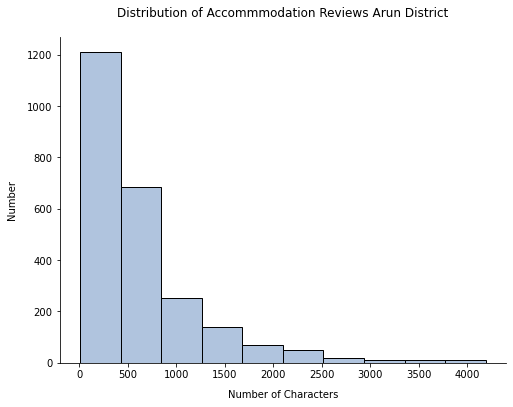

In [28]:
# Plot distribution

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(below_4200["char_len"], bins = 10, color = "lightsteelblue",ec = "black")
ax.set_title("Distribution of Accommmodation Reviews Arun District", fontsize = 12, pad = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Number of Characters",labelpad = 10)
ax.set_ylabel("Number", labelpad = 10)
ax.set_xticks(range(0,4500,500))
plt.show()
              

The Arun dataset is distributed a little differently to the opinion spam accommodation dataset, possibly because the spam dataset is solely hotels but the Arun data includes all types of accommodation. 

# Section 3:  Look for Duplicates

Duplicates were removed in the Exploratory Data Notebook 1. Looking here for reviews with duplicate text with the same user id.
In the study duplicate or similar reviews were assumed to be spam including those with:

* different userids on the same product 
* different userids on different products and 
* the same userid on different products 

In this case, the most likely situation is that a single user posts lots of duplicate or similar reviews on multiple restaurants, or possibly the same user using multiple ids to post on one or multiple establishments. This is very difficult to do in practice, so a situation where the same user is posting multiple duplicate or similar reviews is investigated instead.


Source: Jindal and Liu

Jindal, Nitin & Liu, Bing. (2008). Opinion Spam and Analysis. 10.1145/1341531.1341560. 

https://www.researchgate.net/publication/200044297_Opinion_Spam_and_Analysis/citation/download


In [29]:
# Set text to lower case
arun_df["review_lower"] = arun_df["Review"].apply(lambda x: x.lower())

In [30]:
# Show all items where the id and review text are duplicated in the text
duplicated = arun_df[arun_df.duplicated(["User","review_lower"],keep = False)]
duplicated.shape

(254, 9)

In [31]:
duplicated.head()

,Name,Category,User,Contributions,ReviewDate,Title,Review,Rating,review_lower
1382,Inglenook,Accommodation,emma g,11,2019-05-01,Vegan Treat,"Wow what can I say, I took my Dad and 6 year o...",5,"wow what can i say, i took my dad and 6 year o..."
2650,Oyster Catcher,Food,ejj377,5,2019-12-01,Dreadful Christmas Day meal,Booked back in August for Christmas Day lunch....,1,booked back in august for christmas day lunch....
2652,Oyster Catcher,Food,392nikkim,7,2019-12-01,Terrible!!,We booked in Sept for our christmas dinner spe...,1,we booked in sept for our christmas dinner spe...
2655,Oyster Catcher,Food,ejj377,5,2019-12-27,Dreadful Christmas Day meal,Booked back in August for Christmas Day lunch....,1,booked back in august for christmas day lunch....
2656,Oyster Catcher,Food,392nikkim,7,2019-12-25,Terrible!!,We booked in Sept for our christmas dinner spe...,1,we booked in sept for our christmas dinner spe...


In [32]:
# Remove genuine duplicates
arun_df.drop_duplicates(subset = ["User","review_lower","Title","ReviewDate"],inplace = True)

In [33]:
# Check no duplicates left
arun_df[arun_df.duplicated(["User","review_lower","Title","ReviewDate"],keep = False)]

,Name,Category,User,Contributions,ReviewDate,Title,Review,Rating,review_lower


There were 12 duplicate entries in the data, one was a duplicate across all the columns and the rest were instances where the data varied and are likely to just be errors between the review date and the posting date. All were removed.

# Section 4: Investigate first-time reviewers & proportion of positive singletons

Hypothesis - Fake reviewers posting highly positive ratings tend to be users who have not posted before - 'positive singletons'

Sources and references:

Distortion as a Validation Criterion in the Identification of Suspicious Reviews, 
Guangyu Wu, Derek Greene, Barry Smyth, Pádraig Cunningham

https://snap.stanford.edu/soma2010/papers/soma2010_2.pdf


In [34]:
# Examine differences in rating as per user contributions
arun_df.groupby("Rating")["Contributions"].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1,745.0,21.110067,51.704690,0.0,2.0,5.0,17.00,588.0
2,556.0,37.478417,84.932159,0.0,3.0,13.0,36.00,1064.0
3,877.0,98.397948,233.359234,0.0,7.0,27.0,98.00,2801.0
4,1976.0,196.458502,712.000666,0.0,11.0,46.0,139.25,14575.0
5,6253.0,68.266112,329.551026,0.0,3.0,13.0,45.00,8225.0


Users rating lowest are users with the lowest average previous contributions. Those rating 4-stars have the highest average number of previous contributions. 

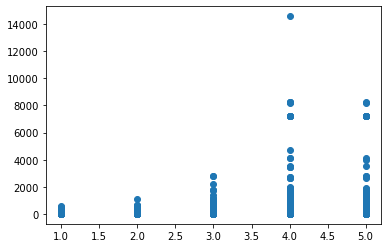

In [35]:
# Look at ratings by number of contributions as a scatter plot
ax =plt.scatter(arun_df["Rating"],arun_df["Contributions"])

The graph seems to show that more active users are giving higher ratings but it is not clear.

In [36]:
# Subset users with NO previous contributions
no_previous = arun_df[arun_df["Contributions"]==0]
no_previous.shape

(382, 9)

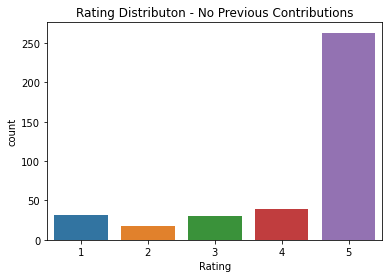

In [37]:
# Distribution of ratings given by users with no previous contributions
import seaborn as sns
y = no_previous["Rating"]
sns.countplot(y, label = "Count")
ax = plt.title("Rating Distributon - No Previous Contributions")

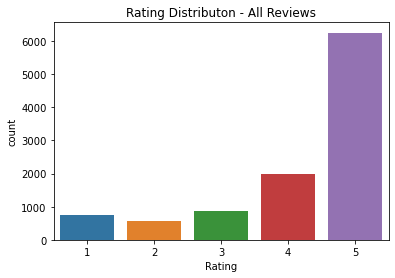

In [38]:
# Compare to distribution of all reviews
y = arun_df["Rating"]
sns.countplot(y, label = "Count")
ax = plt.title("Rating Distributon - All Reviews")

Comparing the histograms of ratings given by users with no previous contributions to the distribution for all users, there does seem to be some difference. New users are giving more 5-star reviews compared to other ratings.

In [39]:
# Create dataframe of rating distributions for all reviews and those of users with no previous contributions
no_prev_sum = pd.DataFrame(no_previous.Rating.value_counts())
arun = pd.DataFrame(arun_df.Rating.value_counts())
comb = pd.concat([no_prev_sum,arun], axis = 1, ignore_index=True)
comb.columns = ["Num No previous","All reviews"]

In [40]:
comb

,Num No previous,All reviews
1,32,745
2,18,556
3,30,877
4,39,1976
5,263,6253


In [41]:
stacked = comb.T.apply(lambda x: x*100/sum(x), axis=1)
stacked

,1,2,3,4,5
Num No previous,8.376963,4.712042,7.853403,10.209424,68.848168
All reviews,7.158643,5.342558,8.427020,18.987220,60.084558


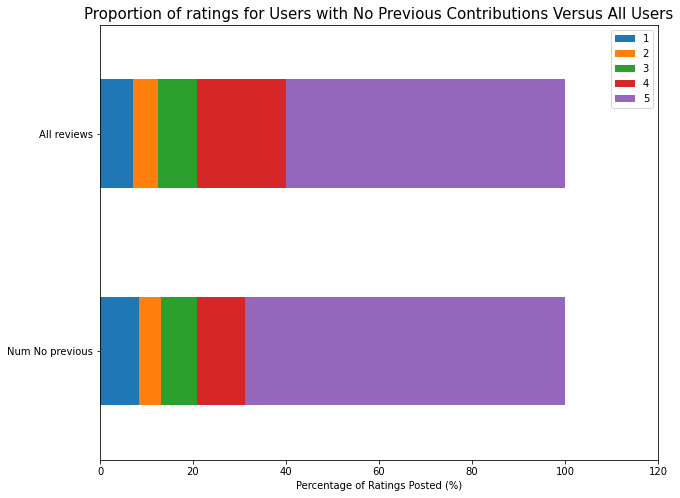

In [42]:
stacked.plot(kind="barh", figsize=(10,8),stacked=True,xlim = (0,120))
plt.title("Proportion of ratings for Users with No Previous Contributions Versus All Users", fontsize =15)
ax = plt.xlabel("Percentage of Ratings Posted (%)")

Analysis: Using stacked barcharts to show the percentage of ratings in each category, it does appear that those with no previous contributions do tend to give proportionately more 5-star ratings than the profile for all reviews but they also give proportionately more 1-star reviews. It may be that first time users are more likely to give ratings at the extreme rather than ratings in between, as they feel motivated enough by their particularly good or particularly bad experience to write a review.

In [43]:
# Looking at it in reverse - of the positive reviews, what proportion are first time contributors?
# Look at the most positive rating of at least 4-stars

print("All reviews:",arun_df.shape[0])
pos_reviews = arun_df[arun_df["Rating"]>=4]
print("Positive reviews:",pos_reviews.shape[0])
first_time = pos_reviews[pos_reviews["Contributions"]==0]
print("First time users positive reviews:",first_time.shape[0])

All reviews: 10407
Positive reviews: 8229
First time users positive reviews: 302


In [44]:
# Percentage of four and five star reviews that are first time contributors - mean positive singletons
first_time.shape[0]/arun_df.shape[0]*100

2.901892956663784

In [45]:
# Percentage relating to each category
first_time.Category.value_counts()

Accommodation    243
Attractions       58
Food               1
Name: Category, dtype: int64

Approximately 3% of all reviews were left by first-time users leaving positive reviews. This is quite low compared to the 30% identified by Wu et al. but the dataset does have a lot of establishments with a large number of reviews, which would reduce the average. Given that shilling is designed to increase ranking, establishments with a lot of reviews are unlikely to be targets for shilling (Wu et al.,2008). The establishments looking to rise up the rankings are more likely to be targets. The bulk of the first-time reviewers were leaving reviews for accommodation. 

Looking at the proportion of first-time singletons out of total reviews by establishment:

In [46]:
# Get the number of all reviews by establishment
all_sorted = pd.DataFrame(arun_df.groupby("Name")["Review"].count().sort_values(ascending = False))
all_sorted.head()

,Review
Name,
Butlins,546
Arundel Castle,296
"Crossbush, Beefeater",189
Avisford,184
Black Rabbit,177


In [47]:
# Get shape of dataframe - number of establishments
all_sorted.shape

(386, 1)

In [48]:
# Get the number of positive reviews by first_time posters grouped by establishment name and sorted descending
positive_sorted = pd.DataFrame(first_time.groupby("Name")["Review"].count().sort_values(ascending = False))
positive_sorted.head()

,Review
Name,
Butlins,44
Travelodge Littlehampton,19
Avisford,19
Premier Inn Littlehampton,19
Travelodge Fontwell,17


In [49]:
# Create combined dataframe 
pos_combined = all_sorted.merge(positive_sorted, on = "Name")
pos_combined.columns = ["All_reviews","First_time_pos"]

In [50]:
# Calculate the proportion of positive singletons (Wu et al.) against all reviews per establishment
pos_combined["PPS"] = pos_combined["First_time_pos"]/pos_combined["All_reviews"]*100

In [51]:
# Sort the values from highest PPS to the lowest
pos_combined.sort_values(by = "PPS",ascending = False).head(20)

,All_reviews,First_time_pos,PPS
Name,,,
The Claremont Inn,2,1,50.000000
Maypole Inn,2,1,50.000000
Rustington Golf Centre,11,4,36.363636
Jaybelle Grange,3,1,33.333333
Claremont Inn,3,1,33.333333
Spring Cottage B&B,7,2,28.571429
Nurse's Cottage,15,4,26.666667
Hawking About,55,14,25.454545
Comfort Inn,16,4,25.000000


In [52]:
# Look at sample items from the highest PPS (change name in code below to check different reviews)
arun_df[arun_df["Name"] == "Jaybelle Grange"]

,Name,Category,User,Contributions,ReviewDate,Title,Review,Rating,review_lower
2371,Jaybelle Grange,Accommodation,Terry K,0,2019-11-01,Fantastic short break,"From start to finish, our stay couldn’t have b...",5,"from start to finish, our stay couldn’t have b..."
2372,Jaybelle Grange,Accommodation,Sam C,7,2019-08-01,"Clean, quiet park",We recently spent a week at Jaybelle Grange Lo...,4,we recently spent a week at jaybelle grange lo...
2373,Jaybelle Grange,Accommodation,Wreckless Eric,322,2019-03-01,Return visit,We came here for the first time in December 20...,5,we came here for the first time in december 20...


In [53]:
# Look at review by first-time user, change name and index to view different results
arun_df[arun_df["Name"] == "Jaybelle Grange"]["Review"].loc[2371]

'From start to finish, our stay couldn’t have been better. Everything was perfect and well thought out. The guy who (I think) runs the site was super friendly and helpful.\nThe lodge itself was beautiful, clean, homely and cosy. My son particularly loved the hot tub. Lovely little extra quirks in the lodge including, board games, reading books and every kitchen utensil you could ever need!\nWe shall certainly be returning here in the near future.'

Analysis: Five places have a PPS score greater than 30% (Wu et al.) although many have scores above the 3% average score over the whole dataset. Examining these reviews they did not appear to be fake.

# Section 5: Investigate First Person Singular Pronouns

First person singular pronouns (I, me, my, mine, myself) often more prevalent in deceptive reviews.

Ott, Myle & Choi, Yejin & Cardie, Claire & Hancock, Jeffrey. (2011). Finding Deceptive Opinion Spam by Any Stretch of the Imagination. 

https://www.cs.cornell.edu/courses/cs4740/2012sp/lectures/op_spamACL2011.pdf

Newman, Matthew & Pennebaker, James & Berry, Diane & Richards, Jane. (2003). Lying Words: Predicting Deception from Linguistic Styles. Personality & social psychology bulletin. 29. 665-75. 10.1177/0146167203029005010. 

https://www.researchgate.net/publication/8436708_Lying_Words_Predicting_Deception_from_Linguistic_Styles


In [54]:
# Check the dataframe
cornell.head()

,deceptive,polarity,text,char_len
0,0.0,positive,We stayed for a one night getaway with family ...,572
1,0.0,positive,Triple A rate with upgrade to view room was le...,286
2,0.0,positive,This comes a little late as I'm finally catchi...,1104
3,0.0,positive,The Omni Chicago really delivers on all fronts...,707
4,0.0,positive,I asked for a high floor away from the elevato...,384


In [55]:
# Check value counts - truthful = zero, deceptive = 1
cornell.deceptive.value_counts()

0.0    800
1.0    800
Name: deceptive, dtype: int64

In [56]:
# Function to extract first person singular pronouns and calculate the proportion of these to all words in a review
def token(df,text):
    first_pronouns = ["i","me","my","myself","mine"]
    df["lower"] = df[text].apply(lambda x: x.lower())
    df["token"] = df["lower"].apply(lambda x: nltk.word_tokenize(x))
    df["token"] = df["token"].apply(lambda x: [e for e in x if e.encode("ascii","ignore")])
    df["len_token"] = df["token"].apply(lambda x: len(x))
    df['pos_tags'] = df['token'].apply(nltk.tag.pos_tag)
    df['pronouns'] = df['pos_tags'].apply(lambda x: [i[0] for i in x if i[1].startswith('PRP')])
    df["first"] = df["pronouns"].apply(lambda x: sum([w in x for w in first_pronouns]))
    df["prop_pronouns"] = df["first"]/df["len_token"]*100
    return df

In [57]:
# Filter out the truthful and deceptive reviews from the labelled Cornell dataset
truthful_reviews = cornell[cornell["deceptive"] == "truthful"]
deceptive_reviews = cornell[cornell["deceptive"] == "deceptive"]

In [58]:
truthful_reviews.head()

,deceptive,polarity,text,char_len


In [59]:
# Process to extract all pronouns from each dataset (Cornell truthful and deceptive and Arun positive reviews)
truthful_reviews_proc = token(truthful_reviews,"text")
deceptive_reviews_proc = token(deceptive_reviews,"text")
arun_proc = token(pos_reviews,"Review")

In [60]:
arun_proc.head(1)

,Name,Category,User,Contributions,ReviewDate,Title,Review,Rating,review_lower,lower,token,len_token,pos_tags,pronouns,first,prop_pronouns
0,Butlins,Accommodation,peggeruk,25,2019-12-01,"Nice break, shame about the accommodation...",We booked our 3 night stay from 27-30 December...,4,we booked our 3 night stay from 27-30 december...,we booked our 3 night stay from 27-30 december...,"[we, booked, our, 3, night, stay, from, 27-30,...",1199,"[(we, PRP), (booked, VBD), (our, PRP$), (3, CD...","[we, our, we, our, it, our, our, you, they, yo...",1,0.083403


In [61]:
# Get the average proportion of first person pronouns for the deceptive reviews, truthful reviews and the Arun positive
print("Deceptive:",deceptive_reviews_proc.prop_pronouns.mean())
print("Truthful:",truthful_reviews_proc.prop_pronouns.mean())
print("Arun Positive:",arun_proc.prop_pronouns.mean())

Deceptive: nan
Truthful: nan
Arun Positive: 0.40942964180909525


In [62]:
# Look at items from the Arun positive dataframe where the proportion of pronouns is greater than the average
pd.DataFrame(arun_proc[["Name","prop_pronouns"]]).sort_values(by = "prop_pronouns",ascending = False).head(10)

,Name,prop_pronouns
3049,"The Windmill, Harvester",9.090909
3775,47 Mussel Row,9.090909
9742,Picturedrome,7.692308
2687,Oyster Catcher,7.407407
4269,Spotted Cow,7.142857
7279,Elmer Tandoori,6.666667
6377,The Mezze,6.451613
3588,Robin Hood,6.451613
3197,"Crossbush, Beefeater",6.451613
4487,World's End,6.250000


In [63]:
# Look at review by first-time user, change name and index to view different results
print(arun_proc[arun_proc["Name"] == "47 Mussel Row"]["Review"].loc[3775])
print(arun_proc[arun_proc["Name"] == "The Windmill, Harvester"]["Review"].loc[3049])
print(arun_proc[arun_proc["Name"] == "Picturedrome"]["Review"].loc[9742])
print(arun_proc[arun_proc["Name"] == "Oyster Catcher"]["Review"].loc[2687])
print(arun_proc[arun_proc["Name"] == "Spotted Cow"]["Review"].loc[4269])

Had a lovely evening with fabulous food. Lots of fish choice for me and delicious lamb dish for my husband.
Me and my family all had a lovely meal and excellent waitress Kelly who was very attentive throughout our evening there.
This picture house is lovely and reminds me of my Saturday morning at the pictures. Lovely little place to see a film.
Read less
Had an lovely meal and time with my wife our waitress liz was so helpful, me and my wife are very greatful by her lovely service
Nathan’s the boy,great service. Nathan one day will rise to the top ranks of the pizza kingdom + he helped me park my Ferrari


Analysis:
The deceptive reviews have a greater proportion of first person pronouns than the truthful reviews from the Cornell dataset. The Arun positive reviews dataset proportion seems to be similar to the truthful reviews and is in lower. Other papers (Newman et al.) contradict the findings of the Cornell paper and conclude that the number of first person pronouns is LESS in deceptive papers but the Cornell paper is based on TripAdvisor reviews so is likely more similar in content and style to the Arun data used here. Looking at a few of the reviews with the highest proportion of pronouns, they did not appear to be suspicious, although it is difficult to be sure. However, it seems that opinion spam is not present in any significant amount by this measure.


# Section 6: Investigate verbs, adverbs, nouns and adjectives

Rayson's work supported by Ott found that nouns and adjectives are more common to informative writing compared to more verbs and adverbs in imaginative writing.

Rayson, Paul & Wilson, Andrew & Leech, Geoffrey. (2001). Grammatical word class variation within the British National Corpus Sampler. Language and Computers. 36. 295-306. 

https://www.researchgate.net/publication/233697720_Grammatical_word_class_variation_within_the_British_National_Corpus_Sampler

Ott, Myle & Choi, Yejin & Cardie, Claire & Hancock, Jeffrey. (2011). Finding Deceptive Opinion Spam by Any Stretch of the Imagination.

https://www.cs.cornell.edu/courses/cs4740/2012sp/lectures/op_spamACL2011.pdf

In [64]:
# Function to find the presence of verbs and adverbs as per Rayson and Ott.

def verbs_adverbs(df,text):
    df["lower"] = df[text].apply(lambda x: x.lower())
    df["token"] = df["lower"].apply(lambda x: nltk.word_tokenize(x))
    df["len_token"] = df["token"].apply(lambda x: len(x))
    df['pos_tags'] = df['token'].apply(nltk.tag.pos_tag)
    df['Verbs'] = df['pos_tags'].apply(lambda x: [i[0] for i in x if i[1].startswith('RB') or i[1].startswith('VB')])
    df['Nouns'] = df['pos_tags'].apply(lambda x: [i[0] for i in x if i[1].startswith('NN') or i[1].startswith('JJ')])
    df["len_verbs"] = df["Verbs"].apply(lambda x: len(x))
    df["len_nouns"] = df["Nouns"].apply(lambda x: len(x))
    df["Verbs_prop"] = df["len_verbs"]/df["len_token"]*100
    df["Nouns_prop"] = df["len_nouns"]/df["len_token"]*100
    return df

In [65]:
# Process to extract proportions of parts of speech from each dataset (Cornell truthful and deceptive and Arun positive reviews)
truthful_reviews_proc = verbs_adverbs(truthful_reviews,"text")
deceptive_reviews_proc = verbs_adverbs(deceptive_reviews,"text")
arun_proc = verbs_adverbs(pos_reviews,"Review")

In [66]:
# Look at top 3 items with the highest proportion of verbs and adverbs in the deceptive dataframe
deceptive_reviews_proc.sort_values(by = "Verbs_prop",ascending = False).head(3)

,deceptive,polarity,text,char_len,lower,token,len_token,pos_tags,pronouns,first,prop_pronouns,Verbs,Nouns,len_verbs,len_nouns,Verbs_prop,Nouns_prop


In [67]:
# Look at top 3 items with the highest proportion of verbs and adverbs in the Arun positive dataframe
arun_proc.sort_values(by = "Verbs_prop",ascending = False).head(3)

,Name,Category,User,Contributions,ReviewDate,Title,Review,Rating,review_lower,lower,...,pos_tags,pronouns,first,prop_pronouns,Verbs,Nouns,len_verbs,len_nouns,Verbs_prop,Nouns_prop
9058,Deligo,Food,Kieren H,1,2019-11-07,Lunch,Great place lovely food very welcoming will de...,5,great place lovely food very welcoming will de...,great place lovely food very welcoming will de...,...,"[(great, JJ), (place, NN), (lovely, RB), (food...",[],0,0.0,"[lovely, very, welcoming, definitely, be, goin...","[great, place, food, family, cafe]",12,5,60.000000,25.000000
8824,Simla Tandoori,Food,461grahamt,7,2019-01-15,"Good food, friendly and good value",Very friendly atmosphere and the staff are alw...,4,very friendly atmosphere and the staff are alw...,very friendly atmosphere and the staff are alw...,...,"[(very, RB), (friendly, RB), (atmosphere, RB),...",[],0,0.0,"[very, friendly, atmosphere, are, always, have...","[staff, helpful, many, times, disappointed]",10,5,52.631579,26.315789
2364,Hangar Down,Accommodation,2012JandBS,45,2019-07-01,Lovely two night stay at the B&B. Alison was w...,"Lovely, relaxing stay",5,"lovely, relaxing stay","lovely, relaxing stay",...,"[(lovely, RB), (,, ,), (relaxing, VBG), (stay,...",[],0,0.0,"[lovely, relaxing]",[stay],2,1,50.000000,25.000000


In [68]:
# Get the average proportion of verbs and adverbs for the deceptive reviews, truthful reviews and the Arun positive
print("Deceptive:",deceptive_reviews_proc.Verbs_prop.mean())
print("Truthful:",truthful_reviews_proc.Verbs_prop.mean())
print("Arun Positive:",arun_proc.Verbs_prop.mean())

Deceptive: nan
Truthful: nan
Arun Positive: 23.150011090133


In [69]:
# Get the average proportion of nouns and adjectives for the deceptive reviews, truthful reviews and the Arun positive
print("Deceptive:",deceptive_reviews_proc.Nouns_prop.mean())
print("Truthful:",truthful_reviews_proc.Nouns_prop.mean())
print("Arun Positive:",arun_proc.Nouns_prop.mean())

Deceptive: nan
Truthful: nan
Arun Positive: 34.682902288908025


Analysis: The proportion of verbs and adverbs and of nouns and adjectives are not very different. The proportion of verbs and adverbs in the Arun positive dataset is similar to that for the deceptive Cornell data, although the proportion of nouns and adjectives, indicating factual writing is HIGHER than both the deceptive and truthful Cornell datasets so this is contradictory to the research. 

Looking at the proportions of verbs and adverbs in the Arun positive reviews a bit closer:


In [70]:
# Get the top establishments with positive reviews and the proportion of verbs and adverbs above the mean for the dataset
top_verbs = pd.DataFrame(arun_proc.groupby("Name")["Verbs_prop"].mean().sort_values(ascending = False))
top_verbs[top_verbs["Verbs_prop"]>arun_proc.Verbs_prop.mean()]

,Verbs_prop
Name,
KFC Bognor,41.666667
Café 77,40.000000
Tesco Café,40.000000
Deligo,36.478495
Jade,36.363636
Fish & Chips,34.883721
Copthorne Caravans,33.076923
Gaston Farm,31.782946
Famous City,31.451125


In [71]:
# How many are above the average for the dataset?
top_verbs[top_verbs["Verbs_prop"]>arun_proc.Verbs_prop.mean()].shape

(174, 1)

There are 174 establishments with the verb and adverb proportion above the average for all positive reviews. The top 5 are all restaurants and with mostly one review.

In [72]:
# Create combined dataframe with the verbs proportion and the number of reviews
num_establishments = pd.DataFrame(arun_proc.Name.value_counts())
num_establishments.columns = ["num_reviews"]
all = num_establishments.merge(top_verbs,left_index = True, right_index = True)
all.sort_values(by = "Verbs_prop",ascending = False).head(10)

,num_reviews,Verbs_prop
KFC Bognor,1,41.666667
Café 77,1,40.000000
Tesco Café,1,40.000000
Deligo,4,36.478495
Jade,1,36.363636
Fish & Chips,1,34.883721
Copthorne Caravans,1,33.076923
Gaston Farm,1,31.782946
Famous City,5,31.451125
Simla Tandoori,4,31.375200


There are 3 establishments where over 40% of the words are verbs or adverbs and they all have just one review

In [73]:
# change name to view different results
arun_proc[arun_proc["Name"] == "Deligo"]

,Name,Category,User,Contributions,ReviewDate,Title,Review,Rating,review_lower,lower,...,pos_tags,pronouns,first,prop_pronouns,Verbs,Nouns,len_verbs,len_nouns,Verbs_prop,Nouns_prop
9057,Deligo,Food,xxspicerxx,16,2019-11-24,Really good food,I have been eating in here for a couple of yea...,5,i have been eating in here for a couple of yea...,i have been eating in here for a couple of yea...,...,"[(i, NNS), (have, VBP), (been, VBN), (eating, ...","[my, it]",1,1.190476,"[have, been, eating, here, recently, changed, ...","[i, couple, years, cafe, hands, food, service,...",28,21,33.333333,25.000000
9058,Deligo,Food,Kieren H,1,2019-11-07,Lunch,Great place lovely food very welcoming will de...,5,great place lovely food very welcoming will de...,great place lovely food very welcoming will de...,...,"[(great, JJ), (place, NN), (lovely, RB), (food...",[],0,0.000000,"[lovely, very, welcoming, definitely, be, goin...","[great, place, food, family, cafe]",12,5,60.000000,25.000000
9059,Deligo,Food,Johnlkitchener,2,2019-07-27,Excellent,Had a full English breakfast quick service fri...,5,had a full english breakfast quick service fri...,had a full english breakfast quick service fri...,...,"[(had, VBD), (a, DT), (full, JJ), (english, JJ...",[],0,0.000000,"[had, friendly, well, presented, be, returning]","[full, english, breakfast, quick, service, exc...",6,10,30.000000,50.000000
9060,Deligo,Food,51PJR,109,2019-08-30,Had breakfast outside In the Bank Holiday,Very good small eating place and they do an ex...,5,very good small eating place and they do an ex...,very good small eating place and they do an ex...,...,"[(very, RB), (good, JJ), (small, JJ), (eating,...",[they],0,0.000000,"[very, do, run, very, was, go, again]","[good, small, eating, place, excellent, breakf...",7,12,22.580645,38.709677


In [74]:
# Look at reviews for these establishments, change name and index to view different results
#print(arun_proc[arun_proc["Name"] == "KFC Bognor"]["Review"].loc[9181])
#print(arun_proc[arun_proc["Name"] == "Café 77"]["Review"].loc[8968])
#print(arun_proc[arun_proc["Name"] == "Tesco Café"]["Review"].loc[9337])
print(arun_proc[arun_proc["Name"] == "Deligo"]["Review"].loc[9057])
print(arun_proc[arun_proc["Name"] == "Deligo"]["Review"].loc[9058])
print(arun_proc[arun_proc["Name"] == "Deligo"]["Review"].loc[9059])
print(arun_proc[arun_proc["Name"] == "Deligo"]["Review"].loc[9060])

I have been eating in here for a couple of years. Recently the cafe changed hands, but the food and service is still really good. I had a full English breakfast in there today, (my first one) and it was delicious. Not greasy, as all the food was oven backed and the eggs poached. The portion was really good too and very reasonably priced. I will be back again for another one soon.
Great place lovely food very welcoming will definitely be going back there highly recommended
Lovely family who own the cafe
Had a full English breakfast quick service friendly and exceptional food perfect portions and well presented
I will be returning
Very good small eating place and they do an excellent breakfast. Run by a very nice couple and the food and service was top notch. Will go again.


Analysis: looking at a sample of reviews, the ones for Deligo all have high indicators for the proportion of verbs and adverbs to other parts of speech and reading these reviews they do appear a little false. The review dates for these reviews are different as are the userid and previous contributions so there are no duplicates. These reviews may well be opinion spam but actually it is very difficult to tell in practice, highlighting the difficulties of using linguistic measures to spot fake reviews. As they represent such a small number of items and unlikely to affect the sentiment analysis significantly, they are retained in the dataset.

# Section 7: A Machine Learning Classification Approach on the Hotel Reviews

## Preprocessing

In [75]:
# Set the target and features for the fake review dataset
y_cornell = cornell.deceptive
X_cornell = pd.DataFrame(cornell.text)

In [76]:
# Drop neutral ratings of 3 and convert other ratings to binary classification
arun_df = arun_df[arun_df["Rating"] != 3]
arun_df["Rating"].replace([1,2],1,inplace = True)
arun_df["Rating"].replace([4,5],0,inplace = True)

In [77]:
arun_hotel = arun_df[arun_df["Category"] == "Accommodation"]

In [78]:
# Set target and features
X_arun = pd.DataFrame(arun_hotel.Review)
y_arun = arun_hotel.Rating

In [79]:
X_arun.shape

(2198, 1)

In [80]:
# Look at a few items
X_arun.head()

,Review
0,We booked our 3 night stay from 27-30 December...
1,In Oyster Bay. Oh dear.\n\nVery poor sound ins...
2,Arrived on 27th dec for 3 night festive break....
3,Just got home a few days ago from our first Ch...
4,"Went for Xmas break for 4 nights,included seei..."


In [81]:
# Get parts of speech tags
def pos(text):
    return TextBlob(text).tags

In [82]:
#joined = ",".join(stop)
#pos_stop = pos(joined)
#print(pos_stop,end = "")

In [83]:
# Define function to process text
def proc(text):
    text = text.apply(lambda x: x.strip().lower())
    text = text.apply(lambda x: nltk.word_tokenize(x))
    punc = string.punctuation
    text = text.apply(lambda x: [word for word in x if word not in punc])
    text = text.apply(lambda x: [n for n in x if not n.isnumeric()])
    text = text.apply(lambda x: [e for e in x if e.encode("ascii","ignore")])
    stop = stopwords.words('english')
    text = text.apply(lambda x: [w for w in x if w not in stop])
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize_text(text):
        return [lemmatizer.lemmatize(w) for w in text]
    text = text.apply(lemmatize_text)
    text = text.apply(lambda x: ' '.join(x))
    return text

In [84]:
# Text process the Cornell dataset and Arun reviews the same way
X_cornell_proc = proc(X_cornell.text)
X_arun_proc = proc(X_arun.Review)

In [85]:
# parts of speech for the Fake dataset
parts = X_cornell_proc.apply(pos)
parts = pd.DataFrame(parts)

# parts of speech for the Arun dataset
parts_arun = X_arun_proc.apply(pos)
parts_arun = pd.DataFrame(parts_arun)

In [86]:
# Check first few rows of the converted Arun data
parts_arun.head()

,Review
0,"[(booked, VBN), (night, NN), (stay, NN), (27-3..."
1,"[(oyster, NN), (bay, NN), (oh, IN), (dear, JJ)..."
2,"[(arrived, VBD), (27th, CD), (dec, NN), (night..."
3,"[(got, VBD), (home, RB), (day, NN), (ago, IN),..."
4,"[(went, VBD), (xmas, JJ), (break, NN), (night,..."


In [87]:
parts_arun.shape

(2198, 1)

In [88]:
# Check output
parts.head()

,text
0,"[(stayed, JJ), (one, CD), (night, NN), (getawa..."
1,"[(triple, JJ), (rate, NN), (upgrade, JJ), (vie..."
2,"[(come, JJ), (little, JJ), (late, JJ), ('m, VB..."
3,"[(omni, NNS), (chicago, VBP), (really, RB), (d..."
4,"[(asked, VBN), (high, JJ), (floor, NN), (away,..."


In [89]:
parts.shape

(1600, 1)

In [90]:
# Convert to a string
parts['pos'] = parts['text'].map(lambda x:" ".join(["/".join(x) for x in x ]) )
parts_arun['pos'] = parts_arun['Review'].map(lambda x:" ".join(["/".join(x) for x in x ]) )

In [91]:
parts_arun.head()

,Review,pos
0,"[(booked, VBN), (night, NN), (stay, NN), (27-3...",booked/VBN night/NN stay/NN 27-30/JJ december/...
1,"[(oyster, NN), (bay, NN), (oh, IN), (dear, JJ)...",oyster/NN bay/NN oh/IN dear/JJ poor/JJ sound/N...
2,"[(arrived, VBD), (27th, CD), (dec, NN), (night...",arrived/VBD 27th/CD dec/NN night/NN festive/JJ...
3,"[(got, VBD), (home, RB), (day, NN), (ago, IN),...",got/VBD home/RB day/NN ago/IN first/JJ christm...
4,"[(went, VBD), (xmas, JJ), (break, NN), (night,...",went/VBD xmas/JJ break/NN night/NN included/VB...


In [92]:
# Merge the dataframes and check first few rows - fake reviews dataset
X_cornell_merged =  pd.merge(X_cornell_proc, parts,right_index=True,left_index = True)
X_cornell_merged.head()

,text_x,text_y,pos
0,stayed one night getaway family thursday tripl...,"[(stayed, JJ), (one, CD), (night, NN), (getawa...",stayed/JJ one/CD night/NN getaway/NN family/NN...
1,triple rate upgrade view room le also included...,"[(triple, JJ), (rate, NN), (upgrade, JJ), (vie...",triple/JJ rate/NN upgrade/JJ view/NN room/NN l...
2,come little late 'm finally catching review pa...,"[(come, JJ), (little, JJ), (late, JJ), ('m, VB...",come/JJ little/JJ late/JJ 'm/VBP finally/RB ca...
3,omni chicago really delivers front spaciousnes...,"[(omni, NNS), (chicago, VBP), (really, RB), (d...",omni/NNS chicago/VBP really/RB delivers/NNS fr...
4,asked high floor away elevator got room pleasa...,"[(asked, VBN), (high, JJ), (floor, NN), (away,...",asked/VBN high/JJ floor/NN away/RB elevator/JJ...


In [93]:
# Merge the dataframes and check first few rows - arun data
X_arun_merged =  pd.merge(X_arun_proc, parts_arun,right_index=True,left_index = True)
X_arun_merged.head()

,Review_x,Review_y,pos
0,booked night stay 27-30 december post-christma...,"[(booked, VBN), (night, NN), (stay, NN), (27-3...",booked/VBN night/NN stay/NN 27-30/JJ december/...
1,oyster bay oh dear poor sound insulation noisy...,"[(oyster, NN), (bay, NN), (oh, IN), (dear, JJ)...",oyster/NN bay/NN oh/IN dear/JJ poor/JJ sound/N...
2,arrived 27th dec night festive break resort de...,"[(arrived, VBD), (27th, CD), (dec, NN), (night...",arrived/VBD 27th/CD dec/NN night/NN festive/JJ...
3,got home day ago first christmas away home say...,"[(got, VBD), (home, RB), (day, NN), (ago, IN),...",got/VBD home/RB day/NN ago/IN first/JJ christm...
4,went xmas break night included seeing santa el...,"[(went, VBD), (xmas, JJ), (break, NN), (night,...",went/VBD xmas/JJ break/NN night/NN included/VB...


## Set up Vectorizer Object and Train Classifiers

In [94]:
# Set training and test split on the fake reviews dataset
X_train, X_test, y_train, y_test = train_test_split(X_cornell_merged["pos"], y_cornell,test_size=0.2, random_state = 0, shuffle = True)

In [95]:
# Convert to vectorizer object
vectorizer = TfidfVectorizer(lowercase = True, use_idf = True, smooth_idf = True,stop_words = "english", norm = 'l2')
#vectorizer = CountVectorizer(max_df=1.0, min_df=1,stop_words = "english")
vectorizer.fit(X_train)

# Transform the training and test set to vectors
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_arun_vector = vectorizer.transform(X_arun_merged['pos'])

In [96]:
# Get shape of training and test sets
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1280, 7559) (320, 7559) (1280,) (320,)


In [97]:
# Function to select parameters

def parameter_select(X_train,y_train):
    C = [0.001,0.01,0.1,1,10]
    g = [0.001,0.01,0.1,1.0]
    param_grid = {'C':C,'gamma':g}
    grid_search = GridSearchCV(svm.SVC(kernel = "linear"),param_grid, cv = 5)
    grid_search.fit(X_train,y_train)
    return grid_search.best_params_

In [98]:
# Run function
parameter_select(X_train,y_train)

{'C': 1, 'gamma': 0.001}

In [99]:
# Define classifier model
model = svm.SVC(kernel = "linear", C = 1,gamma = 0.001)

In [100]:
# Define function to train model
#def train_accuracy(model):
   # kf = KFold(n_splits = 5)
    #scores = cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy',n_jobs =-1)
    #return scores.mean()

In [101]:
# Fit model and predict on test data
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [102]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       155
         1.0       0.86      0.89      0.88       165

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



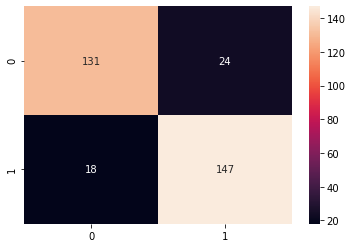

In [103]:
# Confusion Matrix for the fake hotel reviews
cf_matrix = confusion_matrix(y_test, y_pred)
ax =sns.heatmap(cf_matrix, annot = True, fmt = "d",)

# Section 8: Predict Against Arun Hotel Review Data

In [104]:
# Predict against arun data
y_pred_arun = model.predict(X_arun_vector)
y_pred_arun = pd.Series(y_pred_arun)

In [105]:
# Get value counts of labels
y_pred_arun.value_counts()

0.0    1833
1.0     365
dtype: int64

In [106]:
# Reviews predicted to be opinion span
summary = pd.DataFrame(y_pred_arun)
summary.columns = ["Predicted"]

In [107]:
summary[summary["Predicted"] == "deceptive"].shape

(0, 1)

In [108]:
# Percentage of total
summary[summary["Predicted"]== "deceptive"].shape[0]/summary.shape[0]*100

0.0

In [109]:
# Examine sample of reviews - change index to view different review from the opinion spam dataframe above
X_arun.Review.loc[6]

'Currently still here after a weekend at butlins over Christmas break. The kids have loved it. From the fair to swimming to the shows it’s been a great few days. Dreading going home tomorrow. The kids have had a ball. I just want to say all the redcoat, skyline Gang, and the staff work all hours god send. But a special mention to a lady at the cafe in the skyline. I wasn’t sure how to spell her name but I managed to ask for the receipt today and got it. “ELISHA” always served with a smile, made sure my children had there cakes (Oreo ones) and milkshakes and by the second day knew my order, I was visiting in the morning and at night time and she was always smiling and made time to speak. Also made me and my partner the best caramel latte coolers! Yum! Please send this message to her from the pickard family... Also a big thank you to the wave hotel. What amazing service and lovely accommodation. Already thinking of booking for next Christmas.. maybe 5 days this time.\nRead less'

Analysis: the classification model predicted around 17% opinion spam on the hotel reviews. However, looking at sample reviews, they did not appear to be obviously 'fake', perhaps highlighting the problems involved with correctly identifying spam reviews based on only review-centric features such as this. Although this suggests that spam may be more prevalent than the 0.6% of fake reviews getting through that TripAdvisor suggest, 17% is well below the 30% suspected by Fakespot so for the purposes of this review on sentiment it is not considered to be a significant problem.  

# Section 9: Training a Classifier on the YELP Restaurant Reviews

In [110]:
# Take 10% random sample from the dataset
yelp_sampled = yelp.sample(n=35000)
yelp_sampled.shape

(35000, 3)

In [111]:
# Set target and features
y_yelp = pd.DataFrame(yelp_sampled.label)
X_yelp = pd.DataFrame(yelp_sampled.review)

In [112]:
# Balance by taking oversampling from the minority class to match the majority class
oversample = RandomOverSampler(sampling_strategy = "minority")
X_yelp, y_yelp = oversample.fit_resample(X_yelp, y_yelp)

In [113]:
# Set the labels to match output of classifier - set fake reviews to 1 and true reviews to 0
y_yelp['label'] = y_yelp['label'].replace(1,0)
y_yelp['label'] = y_yelp['label'].replace(-1,1)

In [114]:
# Get value_counts of the balanced data
y_yelp.value_counts()

label
0        31401
1        31401
dtype: int64

In [115]:
# Pre-process the text as before
#X_yelp_proc = proc(X_yelp["review"])
#X_yelp_proc = pd.DataFrame(X_yelp_proc)
#X_yelp_proc["parts_of_speech"] = X_yelp_proc["review"].apply(lambda x: pos(x))
#X_yelp_proc['parts_of_speech'] = X_yelp_proc['parts_of_speech'].map(lambda x:" ".join(["/".join(x) for x in x ]) )

In [116]:
# Check the dataframe
X_yelp.sample(5)

,review
42219,Diner had been on my burger list for quite a l...
43785,I pretty much like everything about this place...
15784,Reviews were misleading and my experience here...
41969,"First time ever coming here, and I WILL SURELY..."
1452,"After only one entrée, Café Ollin is already m..."


In [117]:
# Train test split with 20% test size between training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_yelp["review"],y_yelp,test_size = 0.2, shuffle = True, random_state = 42)

In [118]:
# Check the shape
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(50241,) (12561,) (50241, 1) (12561, 1)


In [119]:
# Convert to vectorizer object
vectorizer = TfidfVectorizer(use_idf = True, lowercase = True,stop_words = "english",smooth_idf = True, norm = 'l2')
vectorizer.fit(X_train)

# Transform the training and test set to vectors
X_train_yelp = vectorizer.transform(X_train)
X_test_yelp = vectorizer.transform(X_test)

In [120]:
# Check shape
X_train_yelp.shape

(50241, 40225)

In [121]:
# Define model - parameters as per default as the dataset is large and will take a long time to run)
model = svm.SVC()

In [122]:
# Train on Yelp test data
model.fit(X_train_yelp,y_train)

SVC()

In [124]:
# Predict on test set
y_pred = model.predict(X_test_yelp)

In [125]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6237
           1       0.99      1.00      1.00      6324

    accuracy                           0.99     12561
   macro avg       1.00      0.99      0.99     12561
weighted avg       0.99      0.99      0.99     12561



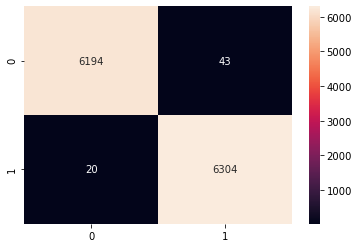

In [126]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
ax =sns.heatmap(cf_matrix, annot = True, fmt = "d",)

In [127]:
# Get value counts of predicted values for the test set
pd.Series(y_pred).value_counts()

1    6347
0    6214
dtype: int64

# Section 10: Using the Yelp trained model with Arun Restaurant Reviews

In [ ]:
# Reviews related to restaurants only
rests = arun_df[arun_df.Category == "Food"]
rests.head(2)

In [ ]:
X_yelp_proc = proc(X_yelp["review"])
X_yelp_proc = pd.DataFrame(X_yelp_proc)
X_yelp_proc["parts_of_speech"] = X_yelp_proc["review"].apply(lambda x: pos(x))
X_yelp_proc['parts_of_speech'] = X_yelp_proc['parts_of_speech'].map(lambda x:" ".join(["/".join(x) for x in x ]) )

In [ ]:
# Predict against the restaurant data using the trained YELP model
X_rests = rests.Review
X_rests_vector = vectorizer.transform(X_rests)
y_pred_rests = lr.predict(X_rests_vector)

In [ ]:
# Create dataframe
results = pd.DataFrame(y_pred_rests,columns = ["Predicted"])
results

In [ ]:
# Get value counts of deceptive (1) versus truthful predicted reviews
results.Predicted.value_counts()

In [ ]:
results.Predicted.value_counts()[1]/results.Predicted.shape[0]*100

In [ ]:
# Look at some examples
print(rests.Review.iloc[4],"\n")
print(rests.Review.iloc[19],"\n")
print(rests.Review.iloc[21],"\n")
print(rests.Review.iloc[28],"\n")
print(rests.Review.iloc[31],"\n")
print(rests.Review.iloc[33],"\n")
print(rests.Review.iloc[41],"\n")
print(rests.Review.iloc[42],"\n")
print(rests.Review.iloc[51],"\n")
print(rests.Review.iloc[52],"\n")

Analysis: almost a quarter of the restaurant reviews are predicted to be fake based on the classifier. This comes close to the Fakespot contention that around 30% of reviews are fake. Restaurant reviews are also often considered to be more likely to be affected by opinion spam. 

Looking at a the first ten of the predicted spam reviews:

* review 1 - has a balance of good and bad points so seems legitimate
* review 2 - seems a little too positive but unclear
* review 3 - comment as for review 1
* review 4 - seems a little suspicious
* review 5 - seems legitimate
* review 6 - could be negative opposition spam
* review 7 - seems legitimate
* review 8 - very wordy and descriptive language, seems it might be fake
* review 9 - comment as for review 1
* review 10 - could be opinion spam

The reviews identified as opinion spam by the model do not all appear to be fake, although it is difficult to know for sure.

Yelp do employ a filtering algorithm and publish the filtered reviews which represent about 16% of total reviews. These reviews tend to be more extreme (favorable or unfavorable) than other reviews (Fake It Till You Make It, 2016).TripAdvisor also use filtering methods using a range of indicators, many of which are not publically available. These might include detailed information regarding the users on the site, their activity, IPs and location as well as the text of the reviews themselves. They maintain that the majority of fake reviews are removed. Since steps are actively taken to moderate reviews, for the purposes of the sentiment analysis, the level of opinion spam is considered to be acceptable but should be borne in mind when considering the results.

Luca, Michael, and Georgios Zervas. "Fake It Till You Make It: Reputation, Competition, and Yelp Review Fraud." Management Science 62, no. 12 (December 2016).

https://dash.harvard.edu/handle/1/22836596
